# Urban Features - OSM within BGs - v2 - Boston
## Boston Metro Area 

In [29]:
#import functions
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

#censusdis
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt

from typing import Optional

import censusdis.data as ced
import censusdis.maps as cem
import censusdis.values as cev
import censusdis.geography as cgeo
from censusdis.states import STATE_MA
import censusdis.states as states
from censusdis.maps import ShapeReader, plot_us_boundary
import censusdis.maps as cmap


# Make sure it is there.
from censusdis.values import ALL_SPECIAL_VALUES



In [2]:
#standard packages
import pandas as pd
import numpy as np
import math
from math import pi, sqrt
import matplotlib.pyplot as plt
# import pygwalker as pyg

# import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime
import time
# from tqdm import tqdm, trange

#gis packages
import osmnx as ox
import logging as lg
ox.settings.log_console=True #use cache to avoid overloading the server
# ox.settings.memory_cache=True #use cache to avoid overloading the server
ox.settings.memory = 4294967296 #set memory cache to 4GB

from shapely.geometry import Point
import folium
import networkx as nx
## future libaries
# import contextily as cx
# import fiona
# from pandana.loaders import osm
# import momepy
# import missingno as msno
# from us import states
# import imageio

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

pd.options.display.max_columns = None # display all columns
pd.options.display.max_rows = None # display all rows

# Gather Census Geometry and Data

### need to replace the code below with an import function using the function "BGs within MSAs"

In [26]:
CENSUS_API_KEY = "781655d3b92f252d48d8acae0f5669dddf3cb9a4"

In [3]:
# import variables file
acs5 = pd.read_csv('C:/Users/jerem/OneDrive/Documents/Git Projects/MeridianXYZ/data/census/ACS Variables.csv')

# pick variables from the "general model" file
acs5 = acs5[acs5['General Model'] == 1].reset_index().drop(['index'], axis=1)
acs5.head()

,Topic,Category,Subcategory,Details,Code,Table Details,General Model,ACS1,Census
0,Age and Sex,Sex by Age,Age and Sex,NaN,B01001,‡†,1.0,NaN,NaN
1,Age and Sex,Median Age by Sex,Age and Sex,NaN,B01002,†,1.0,NaN,NaN
2,Age and Sex,Total Population,Age and Sex,NaN,B01003,NaN,1.0,NaN,NaN
3,Children,Population Under 18 Years by Age,Children,NaN,B09001,NaN,1.0,NaN,NaN
4,Children,Relationship by Household Type (Including Livi...,Children,NaN,B09020,NaN,1.0,NaN,NaN


In [85]:
DATASET = 'acs/acs5'
YEAR = 2022
YEAR_geo = 2020 # for cbsa geometry
# state = STATE_MA

reader = ShapeReader(year=YEAR)

# Variables
TOTAL_POPULATION_VARIABLE = "B01003_001E"
VARIABLE = TOTAL_POPULATION_VARIABLE
VARIABLE_NAME = 'Total Population'
VARIABLES = ["NAME", TOTAL_POPULATION_VARIABLE]
CBSAS = ["14460"]

# Urban Features - Dowload features from OSM within BGs - v2

In [ ]:
counties_ma = ['017', '009', '021', '023', '025'] # ['Middlesex County, Massachusetts', 'Essex County, Massachusetts', 'Norfolk County, Massachusetts', 'Plymouth County, Massachusetts', 'Suffolk County, Massachusetts']

In [24]:
polygon_block_groups = ced.download(
    dataset,
    year,
    variables,
    state = state,
    county = counties_ma,
    tract = '*',
    block_group = "*",
    with_geometry = True,
    # remove_water = True,
    set_to_nan=ALL_SPECIAL_VALUES
)

In [25]:
polygon_block_groups.head()

,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,B01003_001E,geometry
0,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.93006 42.42697, -70.92991 42.427..."
1,25,009,201100,2,Block Group 2; Census Tract 2011; Essex County...,1424,"POLYGON ((-70.93678 42.42779, -70.93336 42.428..."
2,25,009,201100,3,Block Group 3; Census Tract 2011; Essex County...,1092,"POLYGON ((-70.94048 42.44376, -70.93853 42.454..."
3,25,009,202101,1,Block Group 1; Census Tract 2021.01; Essex Cou...,799,"POLYGON ((-70.91486 42.47522, -70.91385 42.475..."
4,25,009,202101,2,Block Group 2; Census Tract 2021.01; Essex Cou...,924,"POLYGON ((-70.91823 42.46837, -70.91671 42.472..."


In [26]:
polygon_block_groups = polygon_block_groups.dropna(subset=['geometry'])
polygon_block_groups.head()

,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,B01003_001E,geometry
0,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.93006 42.42697, -70.92991 42.427..."
1,25,009,201100,2,Block Group 2; Census Tract 2011; Essex County...,1424,"POLYGON ((-70.93678 42.42779, -70.93336 42.428..."
2,25,009,201100,3,Block Group 3; Census Tract 2011; Essex County...,1092,"POLYGON ((-70.94048 42.44376, -70.93853 42.454..."
3,25,009,202101,1,Block Group 1; Census Tract 2021.01; Essex Cou...,799,"POLYGON ((-70.91486 42.47522, -70.91385 42.475..."
4,25,009,202101,2,Block Group 2; Census Tract 2021.01; Essex Cou...,924,"POLYGON ((-70.91823 42.46837, -70.91671 42.472..."


In [27]:
#rename columns
polygon_block_groups = polygon_block_groups.rename(columns={"B01003_001E": "TOTAL_POPULATION"})
# gdf_block_group.head()

In [28]:
# Establish bounds DataFrame (everything so we can do one query)
polygon_block_groups['collapse'] = 0
polygon_block_groups_collapsed = polygon_block_groups.dissolve(by='collapse')
polygon_block_groups_bounds = polygon_block_groups_collapsed.bounds
# print(gdf_block_group_bounds)
# print(gdf_block_group_collapsed)

# Test Maps

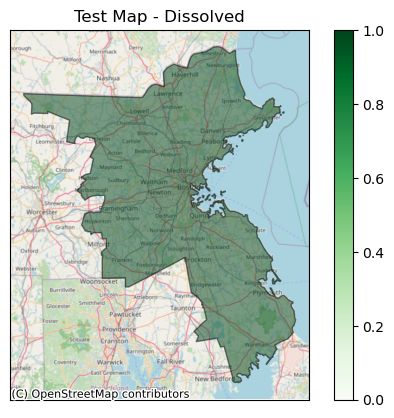

In [29]:
#Plot for test
ax = cem.plot_map(
    polygon_block_groups_collapsed,
    "TOTAL_POPULATION",
    cmap="Greens",
    edgecolor="black",
    alpha=0.5,
    with_background=True,
    legend=True,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title("Test Map - Dissolved")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)

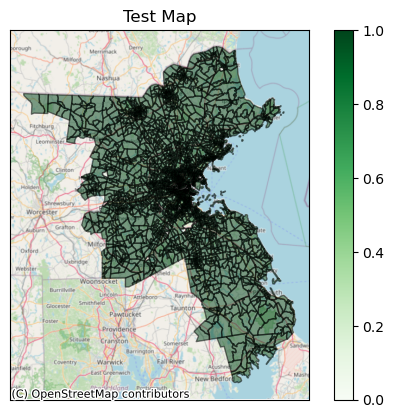

In [30]:
ax = cem.plot_map(
    polygon_block_groups,
    "TOTAL_POPULATION",
    cmap="Greens",
    edgecolor="black",
    alpha=0.5,
    with_background=True,
    legend=True,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title("Test Map")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)

# Load Features

In [18]:
features = [
    'aeroways',
    'amenities',
    'building',
    'healthcare',
    'highway',
    'landuse',
    'leisure',
    'railway',
    'route',
    'shop'
]
features = features[2]  
features

'building'

In [21]:
map_features = pd.read_csv(f'Map Features - {features}.csv')
map_features = map_features.dropna(axis='columns', how='all')
# map_features = map_features.truncate(before=0, after=1)
print("Number of features:", map_features.shape[0])
map_features

Number of features: 100


,key,value
0,building,apartments
1,building,barracks
2,building,bungalow
3,building,cabin
4,building,detached
5,building,dormitory
6,building,farm
7,building,ger
8,building,hotel
9,building,house


In [22]:
map_features_points = pd.DataFrame()

for index, row in map_features.iterrows():
    # Create a dictionary for the current row
    print("index: ", index)
    # print("row: :", row)
    tag = {row.iloc[0]: row.iloc[1]} #make dictionary tag by selecting the key values

    print(tag)

    try:
        map_poi = ox.features.features_from_polygon(polygon_block_groups_collapsed['geometry'][0], tags=tag) #pick polygon shape from dataframe
        map_poi = map_poi.reset_index() #clean index
        map_poi = map_poi[['element_type','osmid','name','geometry']] #keep only useful columns
        map_poi['feature_category'] = row.iloc[0]
        map_poi['feature_type'] = row.iloc[0]+'_'+ row.iloc[1] #create map_feature "name type"
        map_features_points = pd.concat([map_features_points, map_poi])

    except Exception as e:
        print(e)
        continue
# print(map_features_points.describe())
map_features_points.reset_index(inplace=True)

index:  0
{'building': 'apartments'}
index:  1
{'building': 'barracks'}
No data elements in server response. Check log and query location/tags.
index:  2
{'building': 'bungalow'}
"['name'] not in index"
index:  3
{'building': 'cabin'}
index:  4
{'building': 'detached'}
index:  5
{'building': 'dormitory'}
index:  6
{'building': 'farm'}
index:  7
{'building': 'ger'}
No data elements in server response. Check log and query location/tags.
index:  8
{'building': 'hotel'}
index:  9
{'building': 'house'}
index:  10
{'building': 'houseboat'}


C:\Users\Jerem\miniconda3\envs\ox\Lib\site-packages\osmnx\features.py:1045: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


"None of [Index(['element_type', 'osmid', 'name', 'geometry'], dtype='object')] are in the [columns]"
index:  11
{'building': 'residential'}
index:  12
{'building': 'semidetached_house'}
index:  13
{'building': 'static_caravan'}
"['name'] not in index"
index:  14
{'building': 'stilt_house'}
"['name'] not in index"
index:  15
{'building': 'terrace'}
index:  16
{'building': 'tree_house'}
No data elements in server response. Check log and query location/tags.
index:  17
{'building': 'trullo'}
No data elements in server response. Check log and query location/tags.
index:  18
{'building': 'commercial'}
index:  19
{'building': 'industrial'}
index:  20
{'building': 'kiosk'}
index:  21
{'building': 'office'}
index:  22
{'building': 'retail'}
index:  23
{'building': 'supermarket'}
index:  24
{'building': 'warehouse'}
index:  25
{'building': 'religious'}
index:  26
{'building': 'cathedral'}
index:  27
{'building': 'chapel'}
index:  28
{'building': 'church'}
index:  29
{'building': 'kingdom_hall'

C:\Users\Jerem\miniconda3\envs\ox\Lib\site-packages\osmnx\features.py:1045: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


"None of [Index(['element_type', 'osmid', 'name', 'geometry'], dtype='object')] are in the [columns]"
index:  55
{'building': 'farm_auxiliary'}
index:  56
{'building': 'greenhouse'}
index:  57
{'building': 'slurry_tank'}
No data elements in server response. Check log and query location/tags.
index:  58
{'building': 'stable'}
"['name'] not in index"
index:  59
{'building': 'sty'}
No data elements in server response. Check log and query location/tags.
index:  60
{'building': 'livestock'}
No data elements in server response. Check log and query location/tags.
index:  61
{'building': 'grandstand'}
"['name'] not in index"
index:  62
{'building': 'pavilion'}
index:  63
{'building': 'riding_hall'}


C:\Users\Jerem\miniconda3\envs\ox\Lib\site-packages\osmnx\features.py:1045: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


"None of [Index(['element_type', 'osmid', 'name', 'geometry'], dtype='object')] are in the [columns]"
index:  64
{'building': 'sports_hall'}
index:  65
{'building': 'sports_centre'}
index:  66
{'building': 'stadium'}
index:  67
{'building': 'allotment_house'}
"['name'] not in index"
index:  68
{'building': 'boathouse'}
index:  69
{'building': 'hangar'}
index:  70
{'building': 'hut'}
index:  71
{'building': 'shed'}
index:  72
{'building': 'carport'}
index:  73
{'building': 'garage'}
index:  74
{'building': 'garages'}
index:  75
{'building': 'parking'}
index:  76
{'building': 'digester'}
No data elements in server response. Check log and query location/tags.
index:  77
{'building': 'service'}
index:  78
{'building': 'tech_cab'}
No data elements in server response. Check log and query location/tags.
index:  79
{'building': 'transformer_tower'}
No data elements in server response. Check log and query location/tags.
index:  80
{'building': 'water_tower'}
index:  81
{'building': 'storage_tan

C:\Users\Jerem\miniconda3\envs\ox\Lib\site-packages\osmnx\features.py:1045: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


"None of [Index(['element_type', 'osmid', 'name', 'geometry'], dtype='object')] are in the [columns]"
index:  86
{'building': 'construction'}
index:  87
{'building': 'container'}
index:  88
{'building': 'guardhouse'}
"['name'] not in index"
index:  89
{'building': 'military'}
No data elements in server response. Check log and query location/tags.
index:  90
{'building': 'outbuilding'}
"['name'] not in index"
index:  91
{'building': 'pagoda'}
No data elements in server response. Check log and query location/tags.
index:  92
{'building': 'quonset_hut'}
No data elements in server response. Check log and query location/tags.
index:  93
{'building': 'roof'}
index:  94
{'building': 'ruins'}
index:  95
{'building': 'tent'}
"['name'] not in index"
index:  96
{'building': 'tower'}
index:  97
{'building': 'windmill'}
No data elements in server response. Check log and query location/tags.
index:  98
{'building': 'yes'}
index:  99
{'building': 'user defined'}
No data elements in server response. C

In [ ]:
map_features_points

# Intersect Map Feature Points with Block Group Polygons

In [23]:
# Step 1: Ensure CRS matches
print(map_features_points.crs)
print(polygon_block_groups.crs)

polygon_block_groups.crs = map_features_points.crs

print(map_features_points.crs)
print(polygon_block_groups.crs)

epsg:4326
EPSG:4269
epsg:4326
epsg:4326


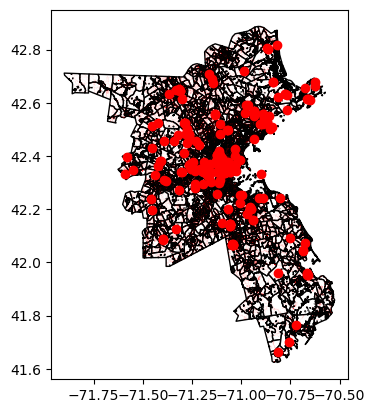

In [24]:
#test plot to see where the amenities are on the map

ax = polygon_block_groups.plot(color='white', edgecolor='black')
map_features_points.plot(ax=ax, color='red')
plt.show()

In [25]:
print(map_features_points.shape)
map_features_points.head()

(1412619, 7)


,index,element_type,osmid,name,geometry,feature_category,feature_type
0,0,way,212207292,Great Hill Student Apartments,"POLYGON ((-70.96151 41.98811, -70.96145 41.988...",building,building_apartments
1,1,way,212207315,Great Hill Student Apartments,"POLYGON ((-70.96207 41.98750, -70.96224 41.987...",building,building_apartments
2,2,way,212207331,Great Hill Student Apartments,"POLYGON ((-70.96242 41.98785, -70.96221 41.987...",building,building_apartments
3,3,way,212207946,NaN,"POLYGON ((-70.96927 41.99267, -70.96932 41.992...",building,building_apartments
4,4,way,215736230,NaN,"POLYGON ((-70.66080 41.94440, -70.66076 41.944...",building,building_apartments


In [26]:
print(polygon_block_groups.shape)
polygon_block_groups.head()

(3270, 8)


,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,TOTAL_POPULATION,geometry,collapse
0,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
1,25,009,201100,2,Block Group 2; Census Tract 2011; Essex County...,1424,"POLYGON ((-70.93336 42.42802, -70.93006 42.426...",0
2,25,009,201100,3,Block Group 3; Census Tract 2011; Essex County...,1092,"MULTIPOLYGON (((-70.93853 42.45409, -70.93878 ...",0
3,25,009,202101,1,Block Group 1; Census Tract 2021.01; Essex Cou...,799,"POLYGON ((-70.91485 42.47522, -70.91385 42.475...",0
4,25,009,202101,2,Block Group 2; Census Tract 2021.01; Essex Cou...,924,"POLYGON ((-70.91823 42.46837, -70.91671 42.472...",0


In [27]:
joined_gdf_test = gpd.sjoin(map_features_points, polygon_block_groups[:1], how='right', predicate='intersects')
joined_gdf_test

# polygon_block_groups[1]

,index_left,index,element_type,osmid,name,feature_category,feature_type,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,TOTAL_POPULATION,geometry,collapse
0,133,133,way,196418545,NaN,building,building_apartments,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,10151,2,way,196419401,NaN,building,building_cabin,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,10152,3,way,196420598,NaN,building,building_cabin,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,20748,1686,way,196418249,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,20755,1693,way,196418257,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,20756,1694,way,196418259,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,20759,1697,way,196418266,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,20760,1698,way,196418269,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,20761,1699,way,196418271,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,20762,1700,way,196418272,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0


In [29]:
#join all point features to polygons one by one

joined_gdf_temp = pd.DataFrame() #create empty dataframe
joined_gdf = pd.DataFrame() #create empty dataframe

for i in range(len(polygon_block_groups)):
    try:
        joined_gdf_temp = gpd.sjoin(map_features_points, polygon_block_groups[i:i+1], how='right', predicate='intersects')
    except Exception as e:
        print(e)
        continue
    joined_gdf = pd.concat([joined_gdf, joined_gdf_temp])

joined_gdf.shape

(1428613, 15)

In [30]:
joined_gdf.head()

,index_left,index,element_type,osmid,name,feature_category,feature_type,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,TOTAL_POPULATION,geometry,collapse
0,133,133,way,196418545,NaN,building,building_apartments,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,10151,2,way,196419401,NaN,building,building_cabin,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,10152,3,way,196420598,NaN,building,building_cabin,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,20748,1686,way,196418249,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0
0,20755,1693,way,196418257,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",0


In [31]:
# Step 2: Spatial Join - This adds the polygon information to each point that falls within it
# joined_gdf = gpd.sjoin(map_features_points, polygon_block_groups, how='right', predicate='intersects')
joined_gdf = joined_gdf.drop((['collapse']), axis=1)
joined_gdf.head()

,index_left,index,element_type,osmid,name,feature_category,feature_type,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,TOTAL_POPULATION,geometry
0,133,133,way,196418545,NaN,building,building_apartments,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428..."
0,10151,2,way,196419401,NaN,building,building_cabin,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428..."
0,10152,3,way,196420598,NaN,building,building_cabin,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428..."
0,20748,1686,way,196418249,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428..."
0,20755,1693,way,196418257,NaN,building,building_house,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428..."


In [32]:
# Step 3: Aggregation - Count points per category within each polygon
counts = joined_gdf.groupby(['NAME', 'feature_type']).size().unstack(fill_value=0)
counts = counts.reset_index()
# print(counts.NAME.unique())
counts.head()

feature_type,NAME,building_apartments,building_barn,building_boathouse,building_bunker,building_cabin,building_carport,building_cathedral,building_chapel,building_church,building_civic,building_college,building_commercial,building_construction,building_container,building_detached,building_dormitory,building_farm,building_farm_auxiliary,building_fire_station,building_garage,building_garages,building_government,building_greenhouse,building_hangar,building_hospital,building_hotel,building_house,building_hut,building_industrial,building_kindergarten,building_kingdom_hall,building_kiosk,building_monastery,building_mosque,building_museum,building_office,building_parking,building_pavilion,building_public,building_religious,building_residential,building_retail,building_roof,building_ruins,building_school,building_semidetached_house,building_service,building_shed,building_sports_centre,building_sports_hall,building_stadium,building_storage_tank,building_supermarket,building_synagogue,building_temple,building_terrace,building_tower,building_train_station,building_transportation,building_university,building_warehouse,building_water_tower,building_yes
0,Block Group 1; Census Tract 1.01; Suffolk Coun...,10,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,154
1,Block Group 1; Census Tract 1.02; Suffolk Coun...,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,179
2,Block Group 1; Census Tract 1001; Suffolk Coun...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90
3,Block Group 1; Census Tract 1002; Suffolk Coun...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,206
4,Block Group 1; Census Tract 1003; Suffolk Coun...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,265


In [33]:
# 'index_right' is the default name for the index of the right GeoDataFrame (gdf_polygons) after sjoin
# If you used custom index names, adjust 'index_right' accordingly

# The result, 'counts', is a DataFrame with the count of points in each category for each polygon

# To merge this info back with your polygons:
# gdf_polygons_with_counts = polygon_block_groups.merge(counts, left_on=True, right_on=True, how='left').fillna(0)
gdf_polygons_with_counts = polygon_block_groups.merge(counts, on="NAME", how="left").fillna(0)
gdf_polygons_with_counts = gdf_polygons_with_counts.drop((['collapse']), axis=1)
# gdf_polygons_with_counts = gdf_polygons_with_counts.drop(['collapse', 'NAME_y'], axis=1)
# gdf_polygons_with_counts = gdf_polygons_with_counts.rename(columns={"NAME_x": "NAME"})
# 'gdf_polygons_with_counts' now contains your original polygon data plus a column for each category
# with counts of points within each polygon

# Step 4: Optionally convert the counts DataFrame back to a GeoDataFrame if needed
# This step is not necessary if you've already merged the counts with your original polygons
gdf_polygons_with_counts.head()

,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,TOTAL_POPULATION,geometry,building_apartments,building_barn,building_boathouse,building_bunker,building_cabin,building_carport,building_cathedral,building_chapel,building_church,building_civic,building_college,building_commercial,building_construction,building_container,building_detached,building_dormitory,building_farm,building_farm_auxiliary,building_fire_station,building_garage,building_garages,building_government,building_greenhouse,building_hangar,building_hospital,building_hotel,building_house,building_hut,building_industrial,building_kindergarten,building_kingdom_hall,building_kiosk,building_monastery,building_mosque,building_museum,building_office,building_parking,building_pavilion,building_public,building_religious,building_residential,building_retail,building_roof,building_ruins,building_school,building_semidetached_house,building_service,building_shed,building_sports_centre,building_sports_hall,building_stadium,building_storage_tank,building_supermarket,building_synagogue,building_temple,building_terrace,building_tower,building_train_station,building_transportation,building_university,building_warehouse,building_water_tower,building_yes
0,25,009,201100,1,Block Group 1; Census Tract 2011; Essex County...,820,"POLYGON ((-70.92991 42.42786, -70.92760 42.428...",1,0,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,210,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189
1,25,009,201100,2,Block Group 2; Census Tract 2011; Essex County...,1424,"POLYGON ((-70.93336 42.42802, -70.93006 42.426...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,507
2,25,009,201100,3,Block Group 3; Census Tract 2011; Essex County...,1092,"MULTIPOLYGON (((-70.93853 42.45409, -70.93878 ...",0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,1,0,0,554
3,25,009,202101,1,Block Group 1; Census Tract 2021.01; Essex Cou...,799,"POLYGON ((-70.91485 42.47522, -70.91385 42.475...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,0,0,0,4,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,293
4,25,009,202101,2,Block Group 2; Census Tract 2021.01; Essex Cou...,924,"POLYGON ((-70.91823 42.46837, -70.91671 42.472...",0,0,0,0,0,0,0,0,3,0,0,0,0,0,4,0,0,0,0,13,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,284


In [34]:
gdf_polygons_with_counts.shape

(3270, 70)

In [35]:
# gdf_polygons_with_counts[['amenity_cafe','amenity_fast_food','leisure_park']].sum(axis=1).sum()


KeyError: "None of [Index(['amenity_cafe', 'amenity_fast_food', 'leisure_park'], dtype='object')] are in the [columns]"

In [36]:
gdf_polygons_with_counts.drop((['geometry']), axis=1).to_csv(f'240403_polygons_with_counts_nogeo - {features}.csv')
gdf_polygons_with_counts.to_csv(f'240403_polygons_with_counts - {features}.csv')

In [ ]:
# gdf_way = gdf_amenities.loc[gdf_amenities["element_type"] == "way"]
# gdf_node = gdf_amenities.loc[gdf_amenities["element_type"] == "node"]

## Select Variables

In [ ]:
# Data from OSM

In [ ]:
# df = pd.read_csv('gdf_polygons_with_counts_nogeo.csv')

# walker = pyg.walk(df)